# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [1]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [2]:
from src.core.models.xgboost import XgboostModel
import pandas as pd


model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_145411/model_0.pickle'
)


feature_importance = pd.read_csv(f"{model.run_directory}/feature_importance.csv")
features = list(feature_importance["feature"][1:50].values)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_145411/model_0.pickle


In [3]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    ctx_item_id,
    ctx_date_month,
    ctx_dept_id,
    ctx_store_id,
    {','.join(config_loader.inventory_sim_required_fields)},
    {config_loader.target_col},
    {config_loader.benchmark_col},
    {','.join(features)}
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=3
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 103646 rows from custom query.


In [4]:
trained_model = main(features = features)
print("last error was 0.12694")

INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.core.clients.bigquery:Loaded 110992 rows from table: walmart_master_table
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-quantile:0.15668	validation_1-quantile:0.15763
[1]	validation_0-quantile:0.13362	validation_1-quantile:0.13488
[2]	validation_0-quantile:0.11544	validation_1-quantile:0.11646
[3]	validation_0-quantile:0.10097	validation_1-quantile:0.10150
[4]	validation_0-quantile:0.09002	validation_1-quantile:0.09012
[5]	validation_0-quantile:0.08208	validation_1-quantile:0.08182
[6]	validation_0-quantile:0.07601	validation_1-quantile:0.07551
[7]	validation_0-quantile:0.07183	validation_1-quantile:0.07144
[8]	validation_0-quantile:0.06825	validation_1-quantile:0.06810
[9]	validation_0-quantile:0.06559	validation_1-quantile:0.06554
[10]	validation_0-quantile:0.06376	validation_1-quantile:0.06409
[11]	validation_0-quantile:0.06223	validation_1-quantile:0.06302
[12]	validation_0-quantile:0.06114	validation_1-quantile:0.06220
[13]	validation_0-quantile:0.06038	validation_1-quantile:0.06174
[14]	validation_0-quantile:0.05977	validation_1-quantile:0.06160
[15]	validation_0-quantile:0.05932	

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_154750/model_0.pickle
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_154750
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_154750
            


last error was 0.12694


## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

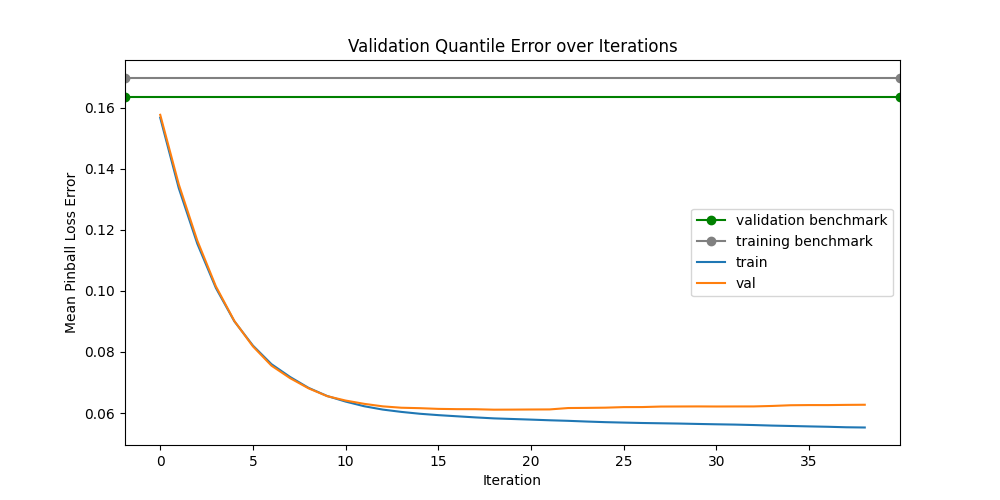

In [5]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

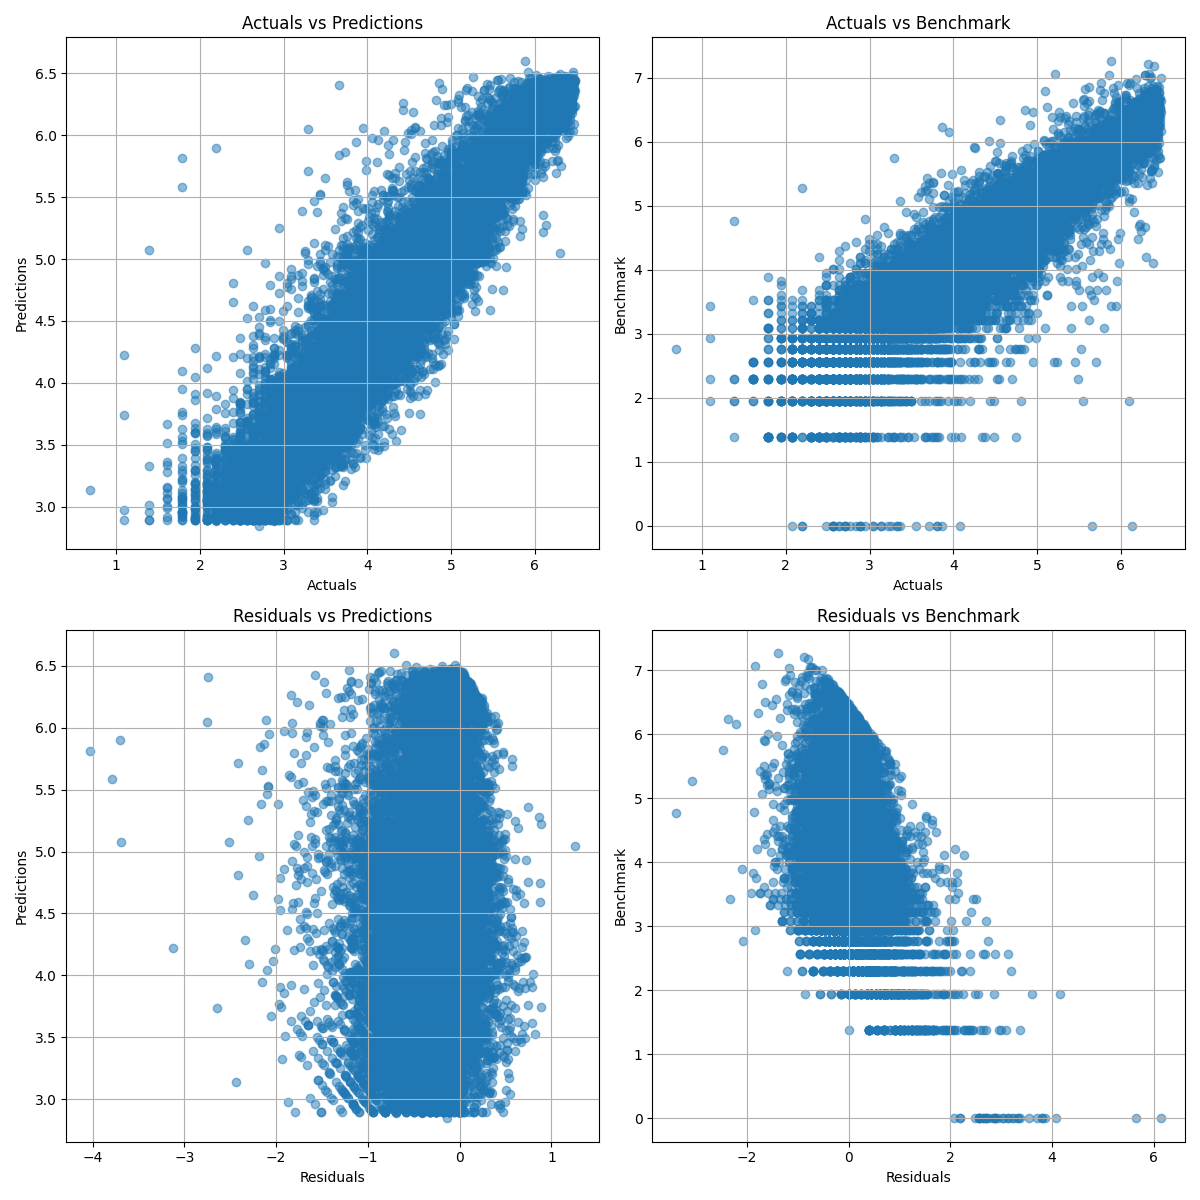

In [6]:
from IPython.display import Image, display
display(Image(trained_model.plot_residuals_paths))

## 8. Feature Importance

In [7]:
trained_model.feature_importance.head(20)

,feature,importance
1,fea_item_monthly_sales_roll_avg_6_months,97.0
5,fea_item_monthly_sales_roll_coeffvar_12_months,86.0
0,feature_avg_sales_not_snap_ca,84.0
3,fea_item_monthly_sales_lag_9_months,72.0
4,fea_item_max_days_since_last_sale,67.0
16,fea_item_vs_dept_price_ratio_min_roll_avg_12_m...,62.0
2,fea_item_monthly_sales_lag_10_months,57.0
15,fea_dept_max_days_since_last_sale,57.0
43,feature_ratio_avg_sales_snap_ca_roll_std_12_mo...,54.0
11,fea_item_monthly_sales_lag_8_months,53.0


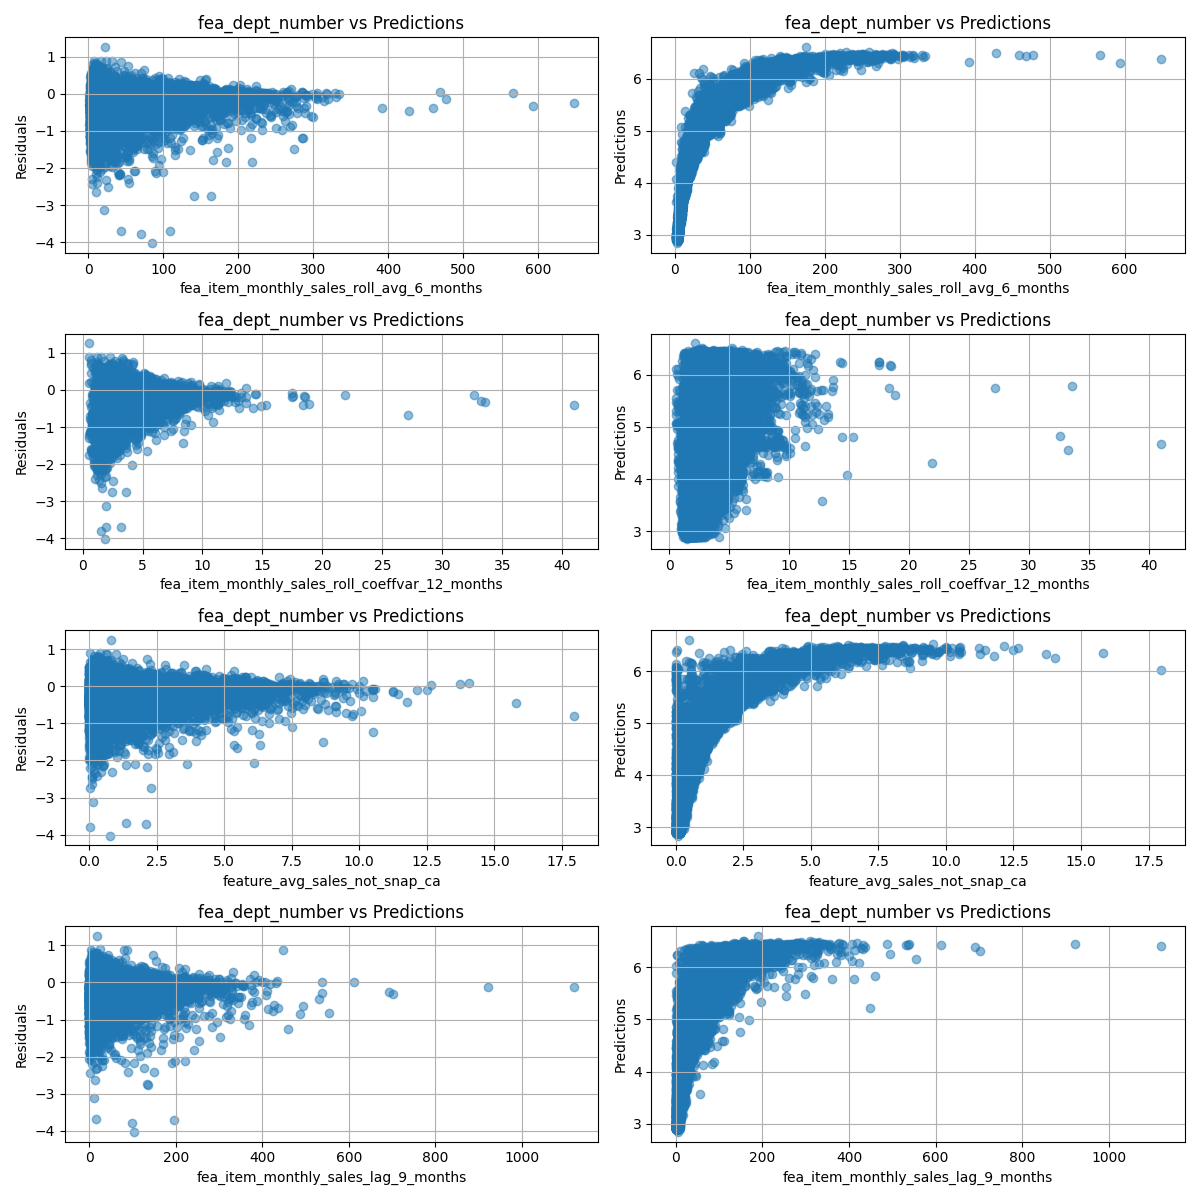

In [8]:
from IPython.display import Image, display
display(Image(trained_model._plot_importance_path))